<a href="https://colab.research.google.com/github/ancastillar/Study-on-the-probability-of-payment-of-a-credit-requested-by-a-customer/blob/main/Model_LOAN_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import pydotplus
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency, norm
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from statsmodels.formula.api import ols
from sympy import var, plot_implicit, Eq
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score 

# ignore log(0) and divide by 0 warning
np.seterr(divide='ignore');
SEED=1

## Decision trees and random forests



##Decision trees##

*   In contrast with linear models, like logistic regression, decision trees can capture non-linear relationship in data.
*   Futhermore, decision trees don't require the features to be on the same scale
* The decision region: region in the feauture space where all instances are assigned to one class label. Produces rectangular decision regions in the feature-space




In [7]:
df = pd.read_csv('/content/drive/MyDrive/data_davivienda/Lending_club.csv',
                 dtype = {'loan_status':'category', 'annual_inc':'float',
                          'verification_status':'category', 'emp_length':'category',
                          'home_ownership':'category', 'int_rate':'object',
                          'loan_amnt':'float', 'purpose':'category',
                          'term':'category', 'grade':'category'})

#Change loan_status, verification_status, emp_length, term and grade to category type 
df.loan_status = df.loan_status.astype(pd.api.types.CategoricalDtype(categories=['Charged Off', 'Fully Paid']))
df.verification_status = df.verification_status.astype(pd.api.types.CategoricalDtype(categories=['Not Verified', 'Source Verified', 'Verified']))
df.emp_length = df.emp_length.astype(pd.api.types.CategoricalDtype(categories=['< 1 year', '1 year', '2 years', '3 years', '4 years', \
                                                             '5 years', '6 years', '7 years', '8 years', '9 years', \
                                                             '10+ years']))
df.home_ownership = df.home_ownership.astype(pd.api.types.CategoricalDtype(categories=['RENT','MORTGAGE','OWN','OTHER']))
df.term = df.term.astype(pd.api.types.CategoricalDtype(categories=[' 36 months', ' 60 months']))
df.grade = df.grade.astype(pd.api.types.CategoricalDtype(categories=['A','B','C','D','E','F','G']))
df.purpose = df.purpose.astype(pd.api.types.CategoricalDtype(categories=['debt_consolidation','credit_card','other','home_improvement','major_purchase','small_business','car', 'wedding','medical','moving','house','vacation','educational','renewable_energy']))

#In addition, the original data in int_rate contains strings of the form 'x.xx%',
#we remove the % and change the vaules to float:
df.int_rate = df.int_rate.str.rstrip('%').astype('float')


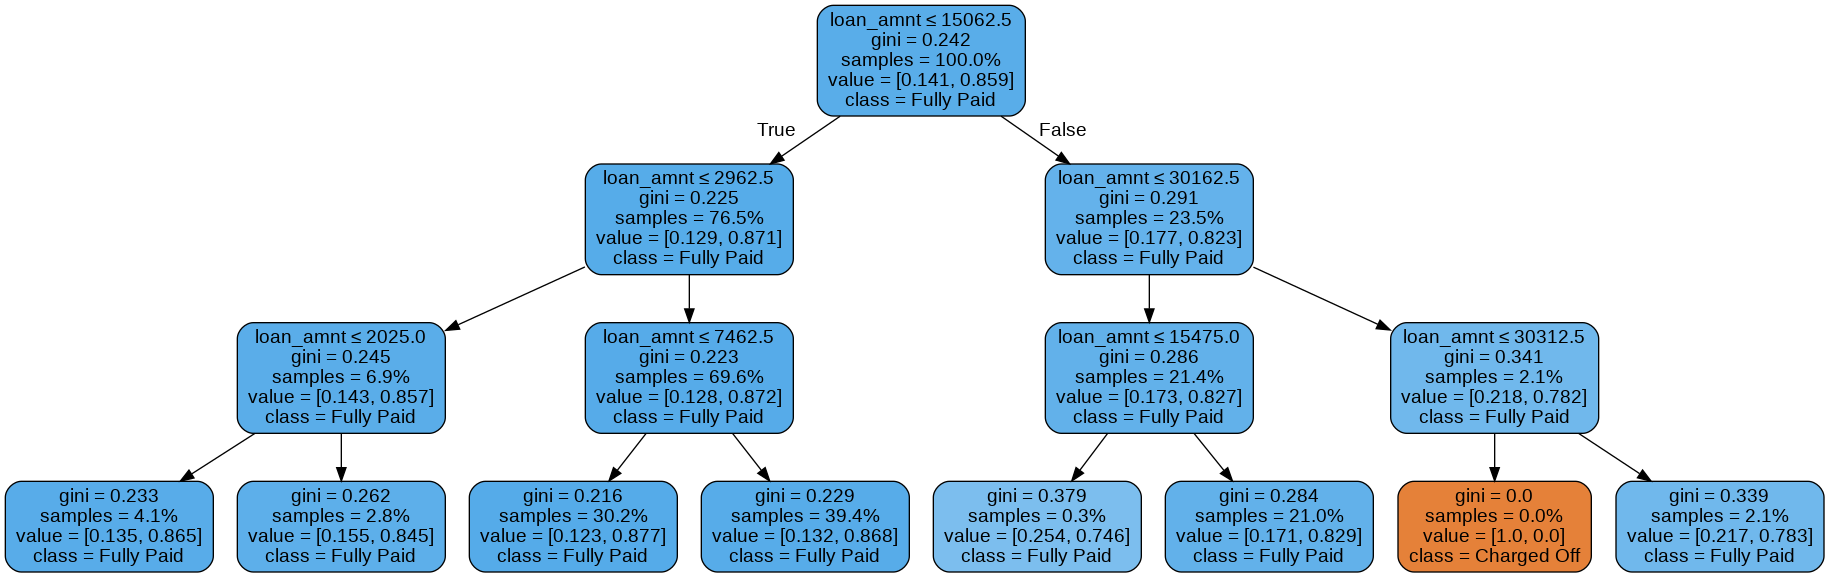

In [8]:
df_t=df.copy()
for var in ['loan_status', 'term','verification_status','grade','home_ownership']:
    df_t[var]=df_t[var].cat.codes


clf = DecisionTreeClassifier(max_depth = 3)

# Train Decision Tree Classifer
covariates=['loan_amnt']

clf = clf.fit(df_t[covariates], df_t['loan_status'])

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names = covariates,
                class_names=['Charged Off', 'Fully Paid'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

We need to determine which variable we are going to put at the beginning of the tree. The algorithm does that with the concept of gain information:


> $\text{IG(f, sp)}= \text{IG(parent)}- ( \frac{N_l}{N}\text{IG(left)}+\frac{N_r}{N}\text{IG(right)})$ 




##training##

In [11]:
df_pre = pd.concat([(df.loan_amnt - df.loan_amnt.mean())/df.loan_amnt.std(),\
                     (df.int_rate - df.int_rate.mean())/df.int_rate.std(),\
                     (df.annual_inc - df.annual_inc.mean())/df.annual_inc.std(),\
                     pd.get_dummies(df.home_ownership, prefix='home', drop_first=True), \
                     pd.get_dummies(df.purpose, prefix='purpose', drop_first=True), \
                     pd.get_dummies(df.grade, prefix='grade',drop_first=True)], axis=1)
df_pre['verification_status'] = df.verification_status.cat.codes
df_pre['emp_length'] = df.emp_length.cat.codes
df_pre['term'] = df.term.cat.codes

In [16]:
y=df.loan_status.cat.codes
X=df_pre
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2, stratify=y,random_state=SEED)              

In [18]:
dt = DecisionTreeClassifier(random_state=SEED)                    

In [19]:
#params
params_dt = {'max_depth':[2,3,4,6], 'min_samples_leaf':[0.12, 0.14, 0.16, 0.18,0.25]}

In [24]:
# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='roc_auc',
                       cv=5,
                       n_jobs=-1)
#training
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 6],
                         'min_samples_leaf': [0.12, 0.14, 0.16, 0.18, 0.25]},

In [28]:
# Extract the best estimator
best_model = grid_dt.best_estimator_
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Predict the test set probabilities of the positive class
y_pred_proba = best_model.predict_proba(X_test)[:,1]

# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print test_roc_auc
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))


Best hyerparameters:
 {'max_depth': 4, 'min_samples_leaf': 0.12}
Test set ROC AUC score: 0.661
